<a href="https://colab.research.google.com/github/PriyaJyesta/IndoorSceneRecognition/blob/main/Phase2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/606 PROJECT')

data_dir  = 'Images'

classes = os.listdir(data_dir)
print(classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['church_inside', 'florist', 'greenhouse', 'pantry', 'bedroom', 'restaurant', 'concert_hall', 'children_room', 'meeting_room', 'toystore', 'office', 'gameroom', 'stairscase', 'corridor', 'laundromat', 'bowling', 'casino', 'bathroom', 'dentaloffice', 'bakery', 'classroom', 'dining_room', 'restaurant_kitchen', 'bookstore', 'laboratorywet', 'fastfood_restaurant', 'tv_studio', 'grocerystore', 'library', 'lobby', 'operating_room', 'cloister', 'jewelleryshop', 'shoeshop', 'prisoncell', 'clothingstore', 'studiomusic', 'poolinside', 'movietheater', 'hospitalroom', 'locker_room', 'computerroom', 'videostore', 'mall', 'artstudio', 'livingroom', 'hairsalon', 'gym', 'museum', 'kindergarden', 'garage', 'kitchen', 'nursery', 'waitingroom', 'closet', 'airport_inside', 'warehouse', 'bar', 'inside_bus', 'elevator', 'deli', 'winecellar', 'subway', 'buffet', 'inside_subway', 't

In [3]:
len(classes)

67

- Using torchvision package to load and prepare dataset.
- Compose creates a series of transformation to prepare the dataset

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Label: bookstore (Image class: 7)


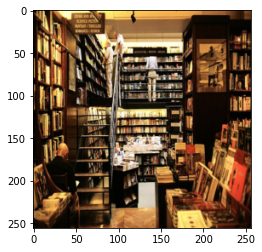

In [5]:
img, label = dataset[3004]
print("Label:",dataset.classes[label],"(Image class: "+ str(label) + ")")
plt.imshow(img.permute(1, 2, 0))

In [6]:
print("Total no. of Images",len(dataset))

Total no. of Images 15620


In [7]:
train, val, test = random_split(dataset, [12000, 3000, 620])
len(train), len(val), len(test)

(12000, 3000, 620)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

In [9]:
train_dl = DataLoader(train, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
model = to_device(ResNet(), device)

In [17]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.028333330526947975, 'val_loss': 4.205019474029541}

In [18]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00006

model_fit = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 3.7369, val_loss: 3.5384, val_acc: 0.5717
Epoch 2: train_loss: 3.4771, val_loss: 3.4512, val_acc: 0.6680
Epoch 3: train_loss: 3.3811, val_loss: 3.4184, val_acc: 0.6993
Epoch 4: train_loss: 3.3287, val_loss: 3.4179, val_acc: 0.7057
Epoch 5: train_loss: 3.2961, val_loss: 3.4074, val_acc: 0.7233
Epoch 6: train_loss: 3.2775, val_loss: 3.4136, val_acc: 0.7413
Epoch 7: train_loss: 3.2670, val_loss: 3.4151, val_acc: 0.7517
Epoch 8: train_loss: 3.2587, val_loss: 3.4244, val_acc: 0.7593
Epoch 9: train_loss: 3.2529, val_loss: 3.4260, val_acc: 0.7510
Epoch 10: train_loss: 3.2484, val_loss: 3.4307, val_acc: 0.7613


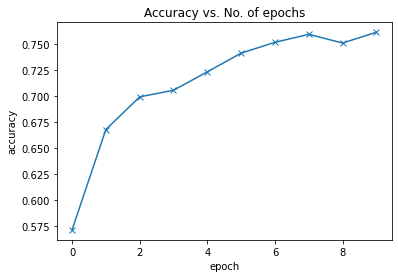

In [20]:
def plot_accuracies_model(model_fit):
    accuracies = [x['val_acc'] for x in model_fit]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies_model(model_fit)

In [21]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.7613333463668823, 'val_loss': 3.430670738220215}

In [22]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: kitchen , Predicted: kitchen


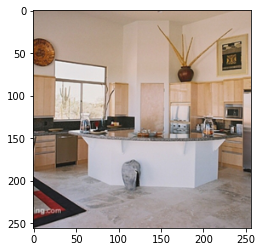

In [23]:
img, label = test[75]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))